In [1]:
SALIENCY_DIR = '/raid/maruf/WSS/SALIENCY/original/image/'
MODEL_FLAG = 'original' # 'noisy'
INPUT_FMT = 'img' # 'crop', 'mask', 'crop_mask'

if INPUT_FMT == 'crop_mask':
    NUM_MASKS = 20
else:
    NUM_MASKS = 50

# SALIENCY_DIR = '/raid/maruf/WSS/SALIENCY/original/image_crop/'
# SALIENCY_DIR = '/raid/maruf/WSS/SALIENCY/original/image_binmask/'
# SALIENCY_DIR = '/raid/maruf/WSS/SALIENCY/original/image_binmask_crop/'

In [2]:
from __future__ import print_function
import os
import sys
sys.path.append('../../../../')
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from PIL import Image
import PIL
import numpy as np
import torch
import torch.optim
from torch.autograd import Variable
from torch import multiprocessing, cuda
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
from torch.backends import cudnn
import seaborn as sns
import importlib
import os
from tqdm import tqdm
import voc12.dataloader
from misc import torchutils, imutils, myutils
import torchvision.transforms as transforms

In [3]:
GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '4'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

num GPUs 1


In [4]:
CLASSNAME_LIST = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
        'bottle', 'bus', 'car', 'cat', 'chair',
        'cow', 'diningtable', 'dog', 'horse',
        'motorbike', 'person', 'pottedplant',
        'sheep', 'sofa', 'train',
        'tvmonitor']

# Load Dataset

In [5]:
from chainercv.datasets import VOCSemanticSegmentationDataset
from chainercv.evaluations import calc_semantic_segmentation_confusion

# ground truth labels in gt_labels

gt_dataset = VOCSemanticSegmentationDataset(split="train",
                                            data_dir='/home/amartyadutta/VOC12/AMN/Datasets/VOCdevkit/VOC2012')

gt_labels = [gt_dataset.get_example_by_keys(i, (1,))[0] for i in range(len(gt_dataset))]


# segmentation dataset and data_loader 

dataset = voc12.dataloader.VOC12ClassificationDatasetMSF(img_name_list_path='/home/amartyadutta/VOC12/AMN/voc12/train.txt',
                                                         voc12_root='/home/amartyadutta/VOC12/AMN/Datasets/VOCdevkit/VOC2012', 
                                                         scales=(1.0,))

data_loader = DataLoader(dataset, shuffle=False)


# NDR gt corresponds to non-deterministic region ground truths

ndr_gt_labels = [np.load(os.path.join('/raid/maruf/WSS/NDR_ground_truth', id + '.npy'), allow_pickle=True) for id in gt_dataset.ids]

# DR gt corresponds to non-deterministic region ground truths

dr_gt_labels = [np.load(os.path.join('/raid/maruf/WSS/DR_ground_truth', id + '.npy'), allow_pickle=True) for id in gt_dataset.ids]

# Load Model

In [6]:
model = getattr(importlib.import_module('net.resnet50_cam'), 'CAM_original')()

if MODEL_FLAG == 'original':
    model.load_state_dict(torch.load('/home/maruf/ws2m2/sess/res50_cam_original_version.pth' + '.pth', map_location='cpu'), strict=True)

elif MODEL_FLAG == 'noisy':
    model.load_state_dict(torch.load('/home/maruf/ws2m2/sess/res50_cam_bin_noise_version.pth' + '.pth', map_location='cpu'), strict=True)
    
model.eval()

model = model.cuda()

# SALIENCY

In [7]:
from torch.utils.data import Dataset

class RandomCropDataset(Dataset):
    def __init__(self, tensor, transform, size=1):
        self.tensor = tensor.squeeze(0)
        self.transform = transform
        self.size = size
    
    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        return self.transform(self.tensor)

t = transforms.Compose([
        transforms.RandomResizedCrop(
            (224, 224),
            scale=(0.05, 0.3), 
            ratio=(0.85, 1.25)
        ),
        transforms.RandomHorizontalFlip(p=0.5),
        # transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 1.5))
    ])
    
def get_saliencies(
    img_tensor,
    target_class,
    input_fmt='img',
    transform=t,
    num_crops=200,
    num_masks = 50
):
    
    
    
    if input_fmt == 'img':
        
        model.zero_grad()
        
        img_tensor.requires_grad = True

        scores = model(img_tensor.type(dtype))

        combined_saliencies = []

        for class_idx in target_class:

            target_score = scores[:, class_idx]

            saliency = torch.autograd.grad(
                target_score, img_tensor,
                grad_outputs = torch.ones_like(target_score),
                retain_graph = True
            )[0]

            saliency = saliency.detach().abs().max(1)[0]
            combined_saliencies.append(saliency)

        raw_saliency = torch.cat(combined_saliencies).detach()
        
        return raw_saliency
        
        
    elif input_fmt == 'crop':
        
        img_tensor.requires_grad = True
        
        dataset = RandomCropDataset(img_tensor, transform, size=num_crops)
        dataloader = DataLoader(dataset, batch_size=100)

        _, _, H, W = img_tensor.shape
        num_classes = len(target_class)
        real_saliencies = torch.zeros(num_classes, 1, H, W).type(dtype)
        
        for batch in dataloader:
            model.zero_grad()
            out = model(batch.type(dtype))
            for i, label in enumerate(target_class):
                label = label.long()
                target_val = out[:,label]
                weights = torch.sigmoid(target_val)
                saliency = torch.autograd.grad(
                                        target_val, img_tensor, 
                                        grad_outputs=weights,
                                        retain_graph=True
                                    )[0]
                saliency = saliency.detach().abs().max(1)[0]
                real_saliencies[i] += saliency.type(dtype)
                
        raw_saliency = real_saliencies.squeeze(1).detach()
        
        return raw_saliency
        
        
    elif input_fmt == 'mask':
        
        _, _, H, W = img_tensor.shape
        num_classes = len(target_class)
        agg_saliencies = torch.zeros(num_classes, H, W).type(dtype)
        
        for _ in range(num_masks):
            
            prob_mask = 0.9 * torch.ones(H, W)
            binary_mask = torch.bernoulli(prob_mask).detach()
            binary_mask.requires_grad = True
            
            noisy_img = img_tensor * binary_mask
            
            model.zero_grad()

            scores = model(noisy_img.type(dtype))

            combined_saliencies = []

            for class_idx in target_class:

                target_score = scores[:, class_idx]

                saliency = torch.autograd.grad(
                    target_score, binary_mask,
                    grad_outputs = torch.ones_like(target_score),
                    retain_graph = True
                )[0]

                saliency = saliency.detach().abs()
                
                combined_saliencies.append(saliency.unsqueeze(0))
                
            raw_saliency = torch.cat(combined_saliencies)
            
            agg_saliencies += raw_saliency.type(dtype)
            
        agg_saliencies /= num_masks
        
        return agg_saliencies
    
    elif input_fmt == 'crop_mask':
        
        _, _, H, W = img_tensor.shape
        num_classes = len(target_class)
        agg_saliencies = torch.zeros(num_classes, H, W).type(dtype)
        
        for _ in range(num_masks):
            
            prob_mask = 0.9 * torch.ones(H, W)
            binary_mask = torch.bernoulli(prob_mask).detach()
            binary_mask.requires_grad = True
            
            noisy_img = img_tensor * binary_mask
            
            #####
            dataset = RandomCropDataset(noisy_img, transform, size=num_crops)
            dataloader = DataLoader(dataset, batch_size=100)

            # _, _, H, W = img_tensor.shape
            # num_classes = len(target_class)
            real_saliencies = torch.zeros(num_classes, H, W).type(dtype)

            for batch in dataloader:
                model.zero_grad()
                out = model(batch.type(dtype))
                for i, label in enumerate(target_class):
                    label = label.long()
                    target_val = out[:,label]
                    weights = torch.sigmoid(target_val)
                    saliency = torch.autograd.grad(
                                            target_val, binary_mask, 
                                            grad_outputs=weights,
                                            retain_graph=True
                                        )[0]
                    saliency = saliency.detach().abs()
                    
                    real_saliencies[i] += saliency.type(dtype)

            raw_saliency = real_saliencies.detach()
            #####
            
            agg_saliencies += raw_saliency.type(dtype)
                    
        agg_saliencies /= num_masks
        
        return agg_saliencies
            

# Save Saliencies

In [8]:
for iter, pack in enumerate(tqdm(data_loader)):
        
    img_name = pack['name'][0]
    
    if os.path.exists(os.path.join(SALIENCY_DIR, img_name+'.npy')):
        continue

    label = pack['label'][0]
    
    target_class = torch.nonzero(label)[:, 0]
    
    input_img = pack['img'][0][0:1, ...]
    
    
    saliency = get_saliencies(img_tensor=input_img,
                              target_class=target_class,
                              input_fmt=INPUT_FMT,
                              num_masks=NUM_MASKS)
    
    np.save(os.path.join(SALIENCY_DIR, img_name+'.npy'), 
                {'saliency': saliency.cpu().numpy(), 'cls_label': target_class})


100%|███████████████████████████████████████████████████████████████████████████████| 1464/1464 [00:16<00:00, 87.72it/s]


# Processing Functions

In [9]:
def smooth(input_saliency):
    '''
    tensor -> tensor
    input_saliency.shape = Num_class, H, W
    output_saliency.shape = Num_class, H, W
    
    '''
    
    input_saliency = input_saliency.unsqueeze(1)
    
    kernel_size, sigma = 13, 5
    
    axis = torch.linspace(-(kernel_size-1)/2., 
                          -(kernel_size-1)/2., 
                          kernel_size)
    gaussian = torch.exp(- 0.5 * axis**2 / sigma**2)
    
    kernel = torch.outer(gaussian, gaussian)[None, None, :, :]
    
    output_saliency = F.conv2d(input_saliency, kernel, padding=kernel_size//2)
    
    return output_saliency.squeeze(1)


In [10]:
def normalization(input_saliency):
    '''
    tensor -> tensor
    input_saliency.shape = Num_class, H, W
    output_saliency.shape = Num_class, H, W
    
    '''
    N_CLASS, H, W = input_saliency.shape
    
    input_saliency = input_saliency.unsqueeze(1)
    
    min_ = input_saliency.view(N_CLASS, -1).min(-1)[0]
    min_ = min_[:, None, None, None].repeat(1, 1, H, W)
    
    max_ = torch.quantile(input_saliency.view(N_CLASS,-1), 
                          0.995, 
                          dim=-1, 
                          interpolation="nearest")
    max_ = max_[:, None, None, None].repeat(1, 1, H, W)
    
    saliency = torch.clamp(input_saliency, max=max_)
    saliency_normalized = (saliency - min_)/(max_ - min_)
    
    return saliency_normalized.squeeze(1)

In [11]:
def subtraction(input_saliency, weights=[1.5, 0.5]):
    '''
    tensor -> tensor
    input_saliency.shape = Num_class, H, W
    output_saliency.shape = Num_class, H, W
    
    '''
    N_CLASS, H, W = input_saliency.shape
    
    input_saliency = input_saliency.unsqueeze(1)
    
    sub_tensor = -1*weights[1]*torch.ones(N_CLASS, N_CLASS) + weights[0]*torch.eye(N_CLASS)
    
    out_saliency = F.relu(torch.einsum("ij,jklm->iklm",
                                       sub_tensor, 
                                       input_saliency))
    return out_saliency.squeeze(1)

In [12]:
def resolve_background(input_saliency, cls_label, thres=0.3):
    '''
    tensor -> ndarray
    input_saliency.shape = Num_class, H, W
    cls_label = sal_obj['cls_label']
    predicted_saliency.shape = H, W
    '''
    
    saliency = subtraction(input_saliency)
    saliency_ndarray = normalization(saliency).cpu().numpy()
    
    saliency_bg = np.pad(saliency_ndarray, 
                  ((1, 0), (0, 0), (0, 0)), 
                  mode='constant', 
                  constant_values=thres)
    
    keys = np.pad(cls_label + 1, 
                  (1, 0), 
                  mode='constant')
    
    cls_labels = np.argmax(saliency_bg, axis=0)
        
    predicted_saliency = keys[cls_labels]
    
    return predicted_saliency

In [13]:
def super_pixel_prediction(input_saliency, img_name, thres=0.1, fmt='absolute'):
    '''
    tensor -> ndarray
    input_saliency.shape = Num_class, H, W
    predicted_class.shape = H, W
    '''
    saliency_ndarray = input_saliency.cpu().numpy()
    
    N_CLASS, H, W = input_saliency.shape
    
    sp_onehot_mask = np.load(f"/data/voc12/superpixel/masks/{img_name}.npy")
    
    predicted_mask = [np.zeros_like(saliency_ndarray[0])+1e-8]
    
    for idx in range(N_CLASS):
        
        saliency = saliency_ndarray[idx]
        scattered_saliency = sp_onehot_mask * saliency[None, :, :]
        sp_score = scattered_saliency.sum((1, 2))/sp_onehot_mask.sum((1, 2))
        
        if fmt=='absolute':
            selected_mask = sp_score > thres
            
        else:
            selected_mask = sp_score > (thres * sp_score.mean())
            
        aggregated_saliency = scattered_saliency[selected_mask].sum(0)
        
        predicted_mask.append(aggregated_saliency)
        
    predicted_class = np.stack(predicted_mask).argmax(0)
    
    return predicted_class
            

In [14]:
def get_predictions(thres=0.25, smoothing=False, superpixel=False):
    
    preds = []
    
    for id in tqdm(gt_dataset.ids):
        
        sal_obj = np.load(os.path.join(SALIENCY_DIR, id + '.npy'), allow_pickle=True).item()
        
        saliency = sal_obj['saliency']
    
        cls_label = sal_obj['cls_label']
        
        img_name = id
        
        keys = np.pad(cls_label + 1, 
                      (1, 0), 
                      mode='constant')
        
        saliency_tensor = torch.tensor(saliency)
        
        if smoothing:
            
            saliency_tensor = smooth(saliency_tensor)
            
            saliency_tensor = normalization(saliency_tensor)
            
        if superpixel:
            
            saliency_tensor = subtraction(saliency_tensor)
            
            saliency_tensor = normalization(saliency_tensor)
            
            cls_labels = super_pixel_prediction(saliency_tensor, 
                                                img_name, 
                                                thres=thres, 
                                                fmt='absolute')
            cls_labels = keys[cls_labels]
            
            preds.append(cls_labels.copy())
            
        else:
            cls_labels = resolve_background(saliency_tensor, 
                                            cls_label, 
                                            thres=thres)
            preds.append(cls_labels.copy())
        
    return preds

In [34]:
def viz_first_n_saliencies(options, n=1, thres=0.25):
    
    for iter, pack in enumerate(data_loader):
        
        img_name = pack['name'][0]
        
        input_img = pack['img'][0][0:1, ...]
        
        sal_obj = np.load(os.path.join(SALIENCY_DIR, img_name + '.npy'), allow_pickle=True).item()
        
        saliency = sal_obj['saliency']
    
        cls_label = sal_obj['cls_label']
        
        keys = np.pad(cls_label + 1, 
                      (1, 0), 
                      mode='constant')
        
        saliency_tensor = torch.tensor(saliency)
        
        preds = []
        
        if options['smoothing']:
            
            saliency_tensor = smooth(saliency_tensor)
            
            saliency_tensor = normalization(saliency_tensor)
            
        if options['superpixel']:
            
            saliency_tensor = subtraction(saliency_tensor)
            
            saliency_tensor = normalization(saliency_tensor)
            
            cls_labels = super_pixel_prediction(saliency_tensor, 
                                                img_name, 
                                                thres=thres, 
                                                fmt='absolute')
            cls_labels = keys[cls_labels]
            
            preds.append(cls_labels.copy())
            
        else:
            cls_labels = resolve_background(saliency_tensor, 
                                            cls_label, 
                                            thres=thres)
            preds.append(cls_labels.copy())
        
        
        predicted_saliency = preds[0]
        gt_label = gt_labels[iter]
        ndr_gt_label = ndr_gt_labels[iter]
        dr_gt_label = dr_gt_labels[iter]
        
        fig, ax = plt.subplots(1, 3, figsize=(12, 3))
        ax[0].imshow(myutils.unnormalize_image(input_img))
        ax[0].axis('off')
        ax[0].set_title('iou:{:.2f}\nNDR-Recall:{:.2f}\nDR-Recall:{:.2f}\nFG-Precision:{:.2f}'.format(compute_miou([predicted_saliency], [gt_label]),
                                                                                                      compute_ndr_recall([predicted_saliency], [ndr_gt_label]),
                                                                                                      compute_dr_recall([predicted_saliency], [dr_gt_label]),
                                                                                                      compute_mPrecision([predicted_saliency], [gt_label])))
        sns.heatmap(gt_label, vmax='20', cmap='tab20', ax=ax[1])
        ax[1].axis('off')
        ax[1].set_title('Ground Truth')
        sns.heatmap(predicted_saliency, vmax='20', cmap='tab20', ax=ax[2])
        ax[2].axis('off')
        ax[2].set_title('Saliency prediction')
        plt.show()
        
        if iter+1 == n:
            break
        
   

## miou functions

In [35]:
from metrics.metric import compute_miou, compute_dr_recall, compute_ndr_recall, compute_mPrecision


In [36]:
def get_predictions_by_imgname(img_name, thres=0.25, smoothing=False, superpixel=False):
    
    preds = []
        
    sal_obj = np.load(os.path.join(SALIENCY_DIR, img_name + '.npy'), allow_pickle=True).item()

    saliency = sal_obj['saliency']

    cls_label = sal_obj['cls_label']

    keys = np.pad(cls_label + 1, 
                  (1, 0), 
                  mode='constant')

    saliency_tensor = torch.tensor(saliency)

    if smoothing:

        saliency_tensor = smooth(saliency_tensor)

        saliency_tensor = normalization(saliency_tensor)

    if superpixel:

        saliency_tensor = subtraction(saliency_tensor)

        saliency_tensor = normalization(saliency_tensor)

        cls_labels = super_pixel_prediction(saliency_tensor, 
                                            img_name, 
                                            thres=thres, 
                                            fmt='absolute')
        cls_labels = keys[cls_labels]

        preds.append(cls_labels.copy())

    else:
        cls_labels = resolve_background(saliency_tensor, 
                                        cls_label, 
                                        thres=thres)
        preds.append(cls_labels.copy())
        
    return preds[0]

# Visualization

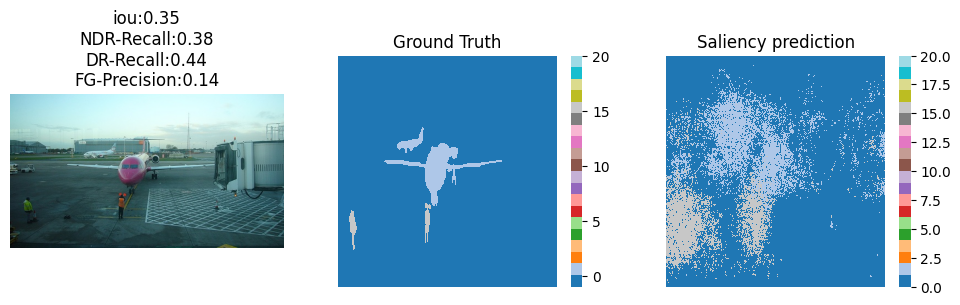

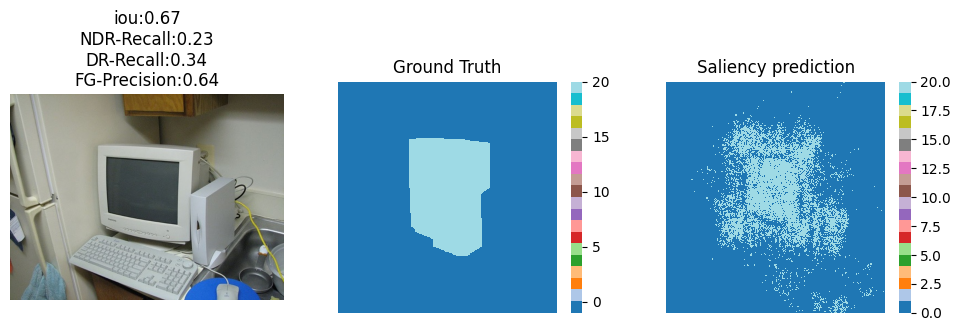

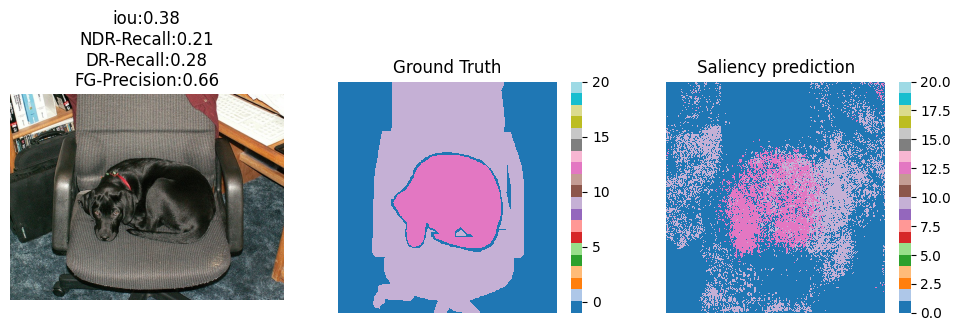

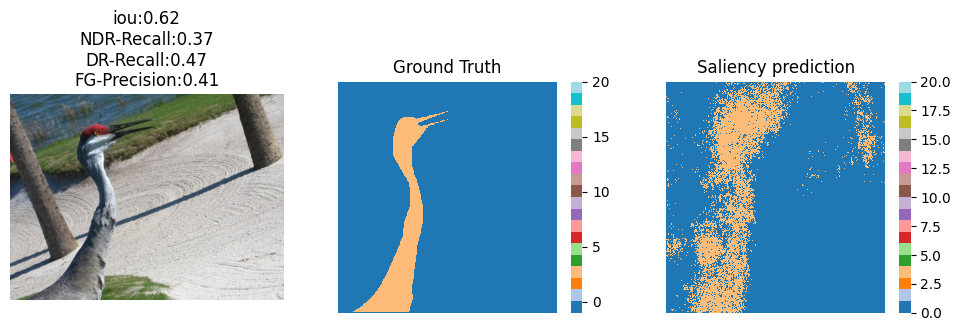

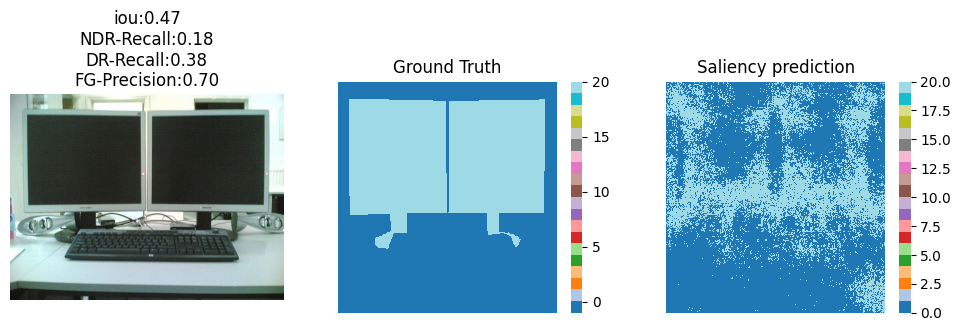

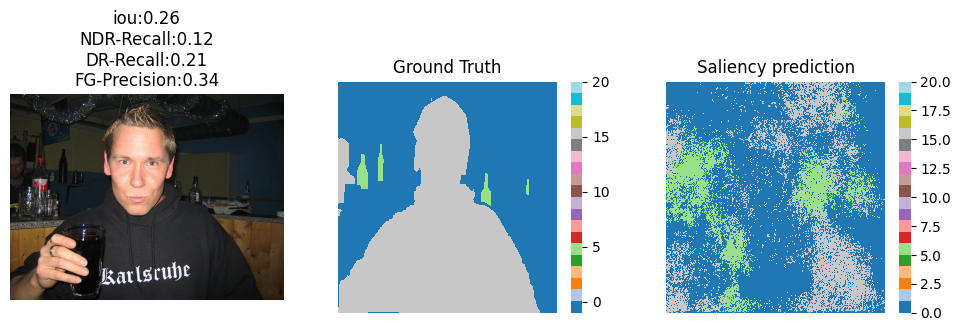

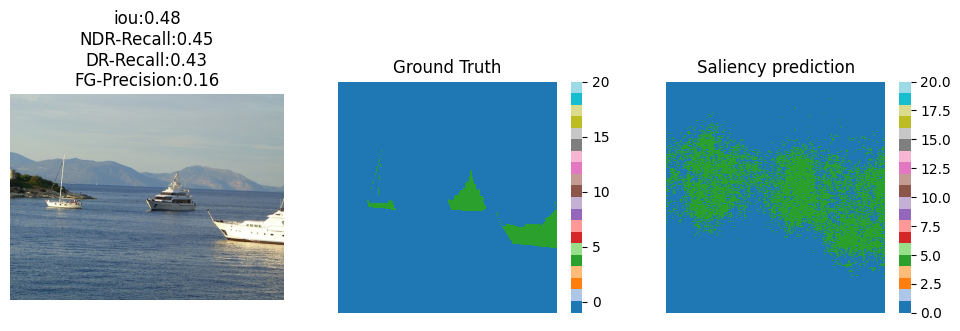

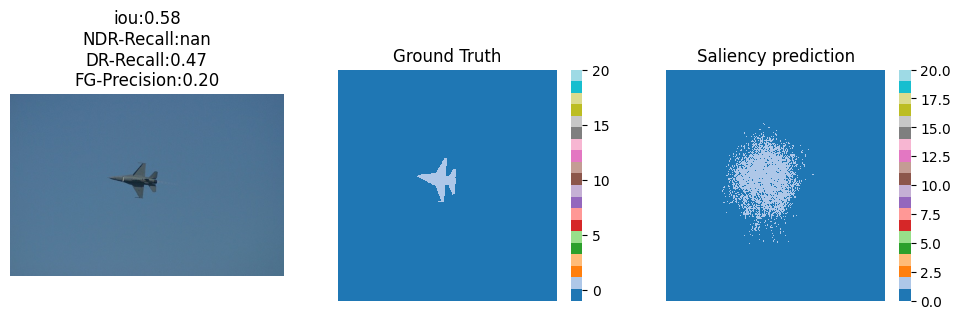

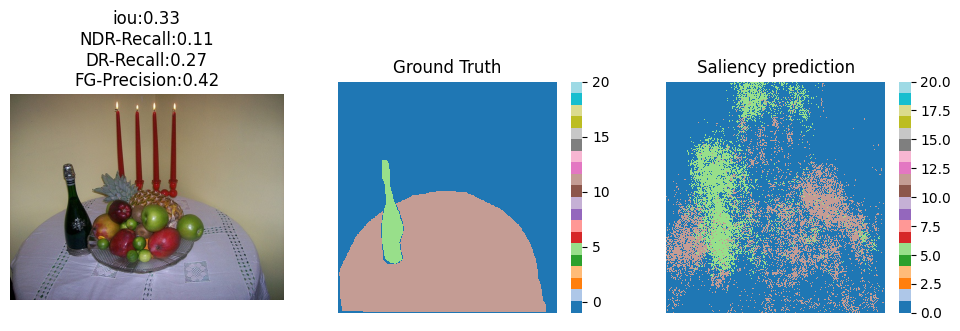

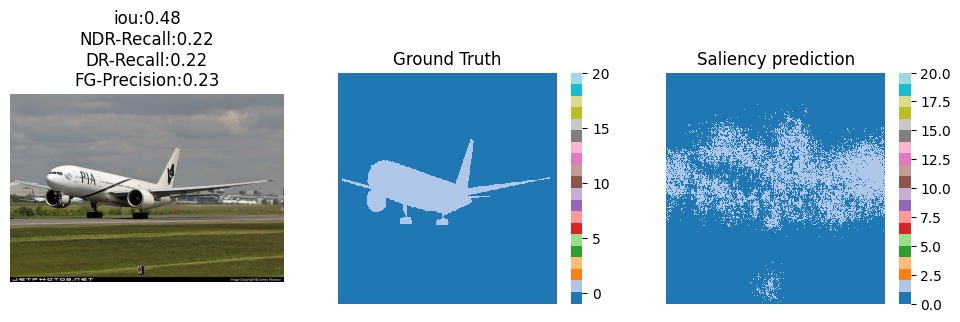

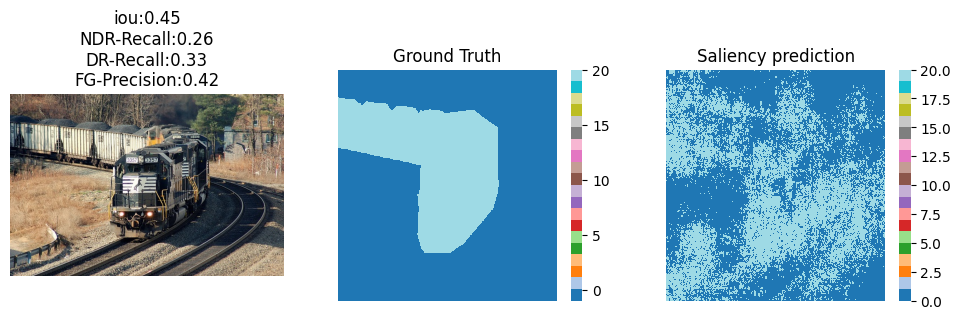

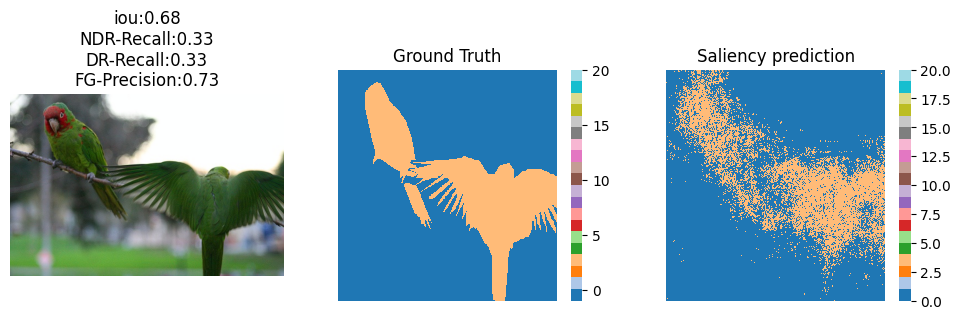

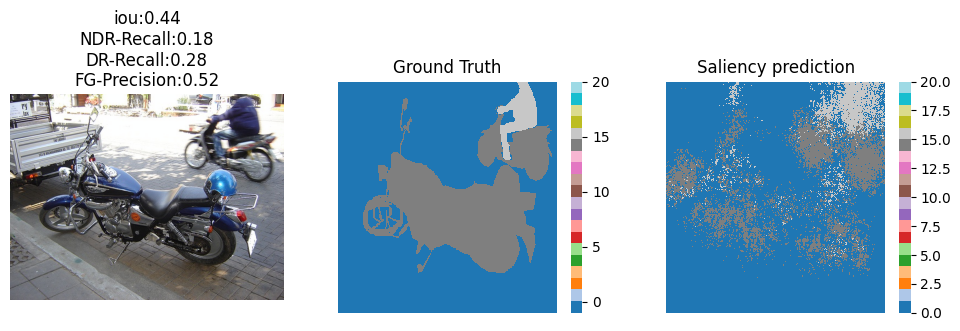

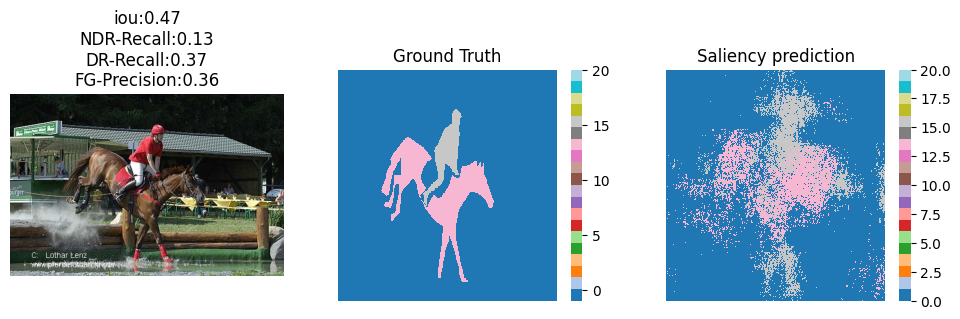

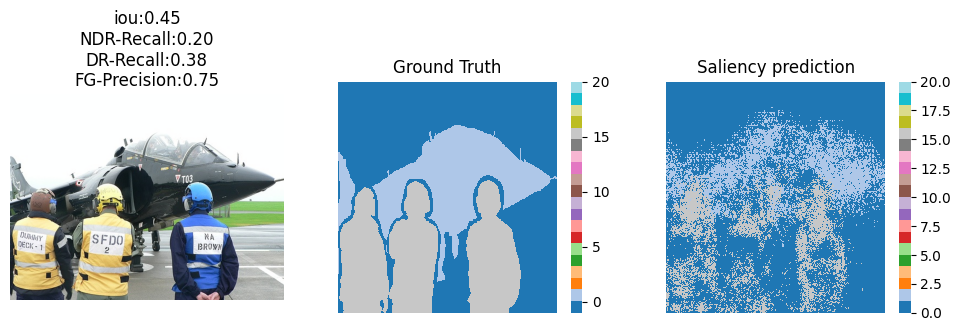

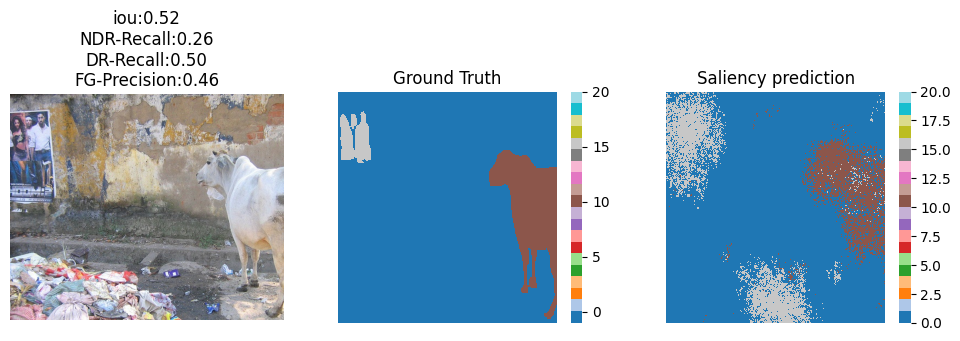

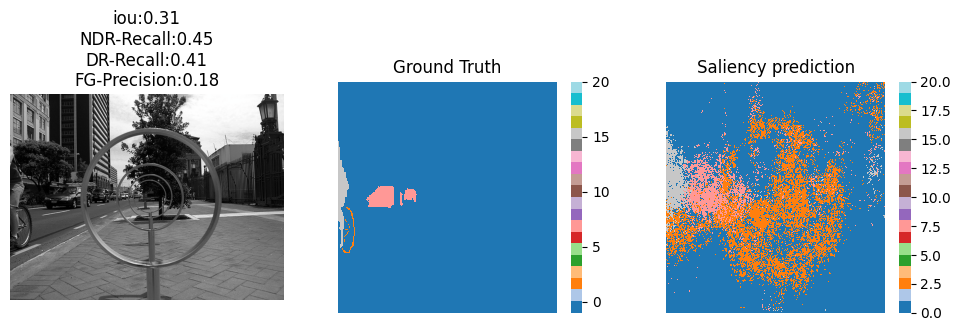

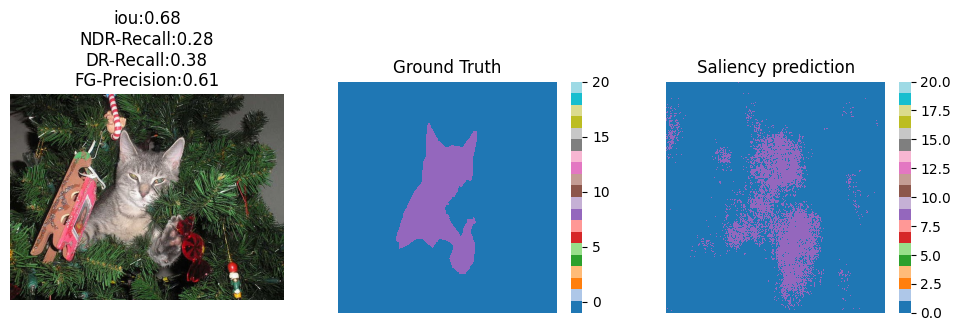

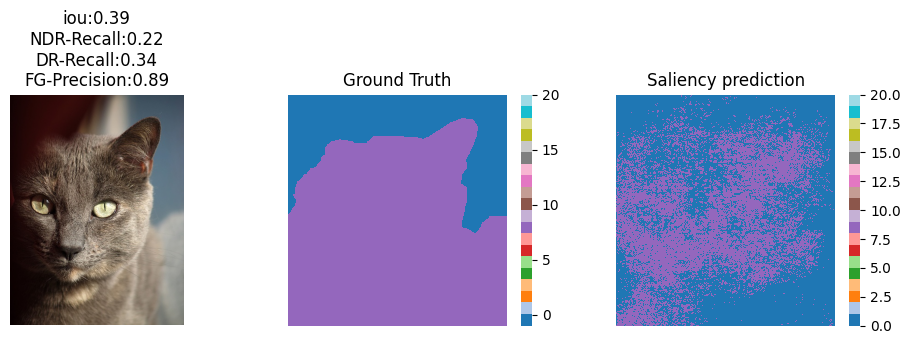

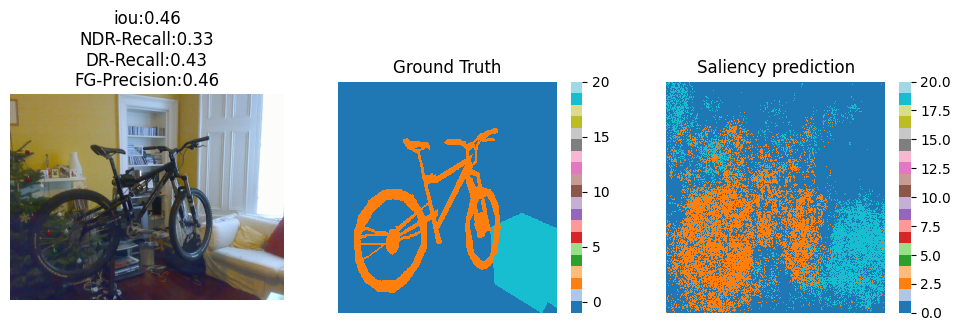

In [37]:
options = {
    'smoothing': False,
    'superpixel': False,
}

viz_first_n_saliencies(options, n=20, thres=0.15)

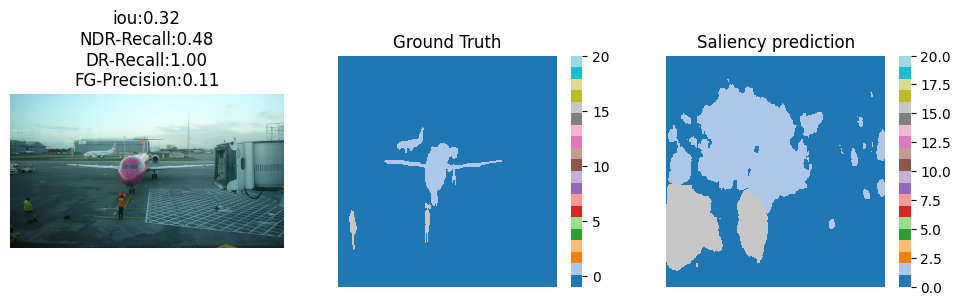

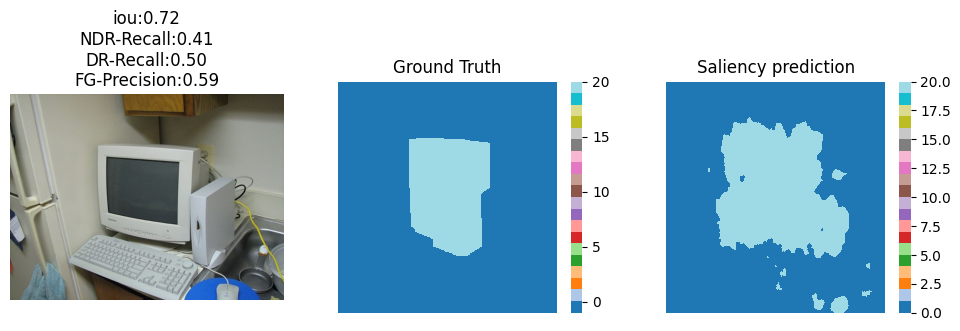

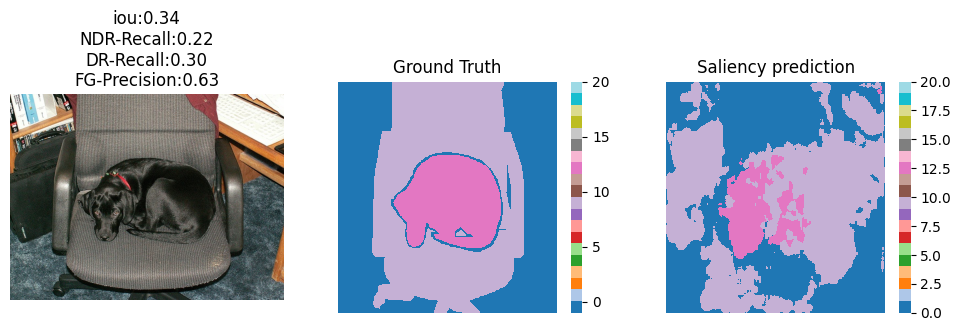

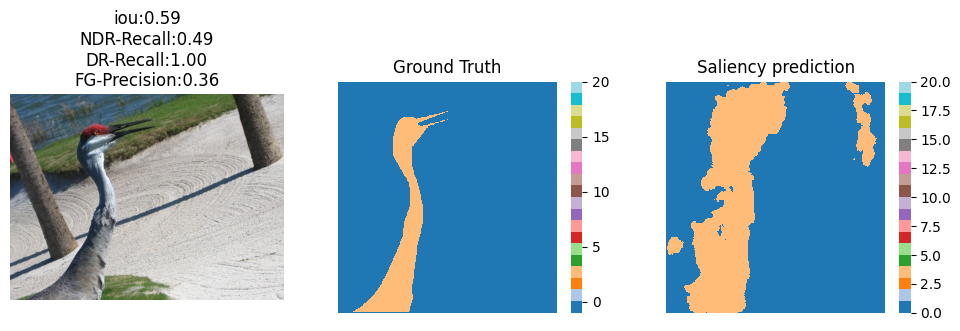

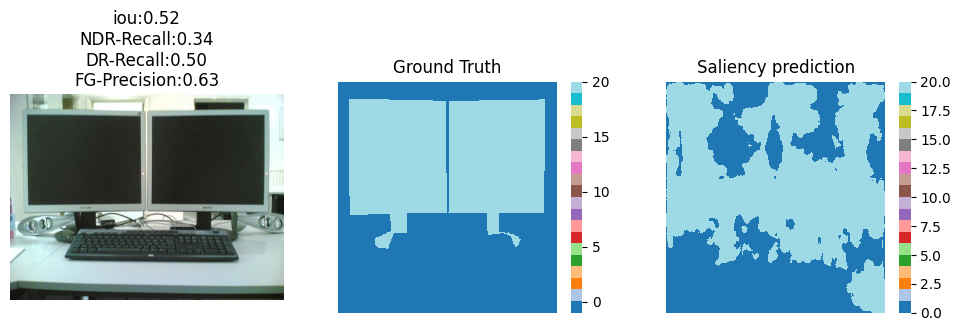

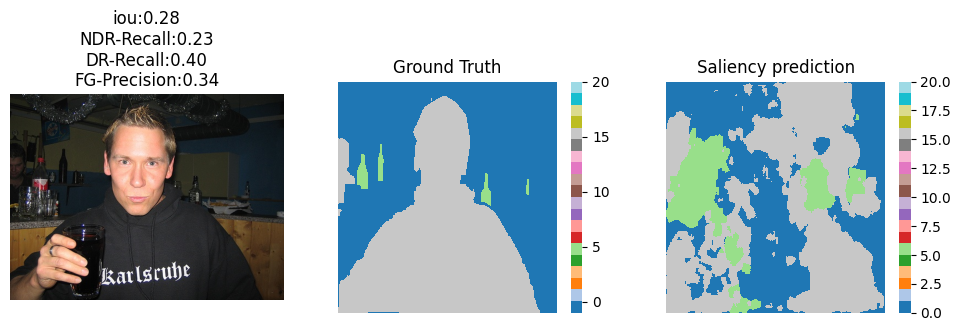

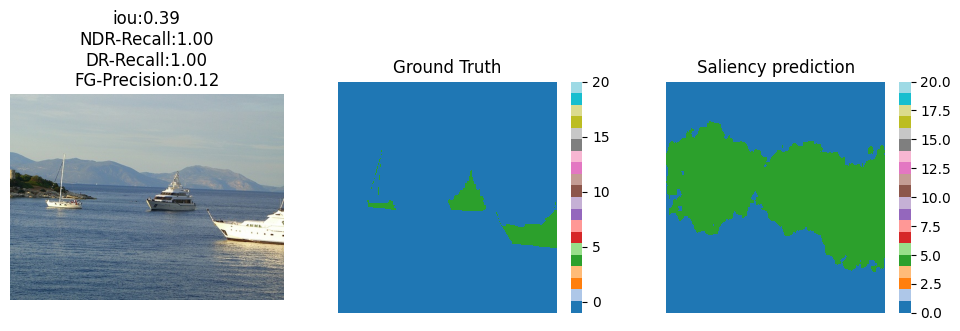

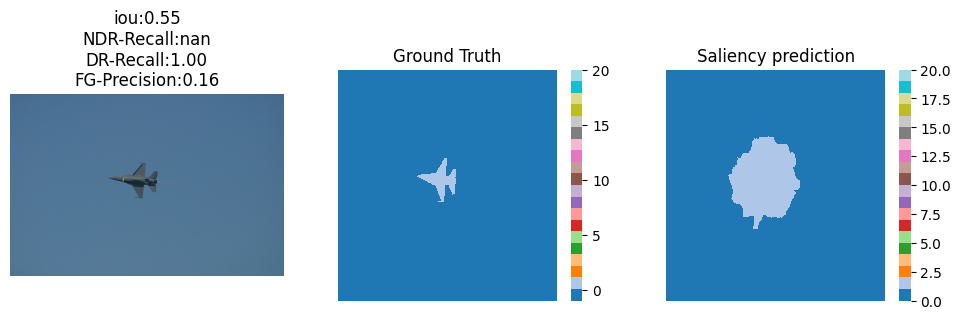

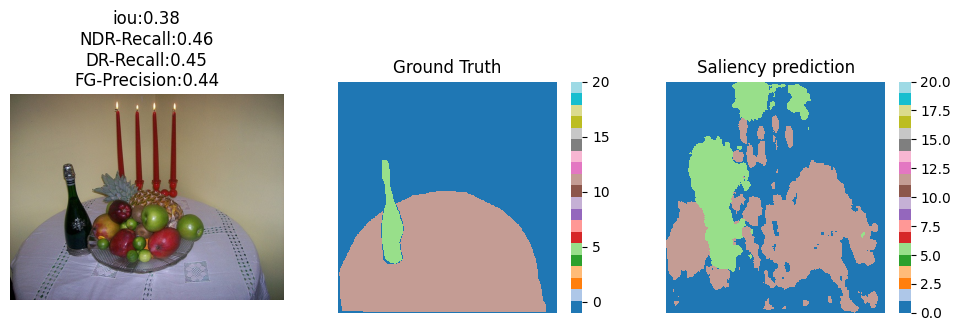

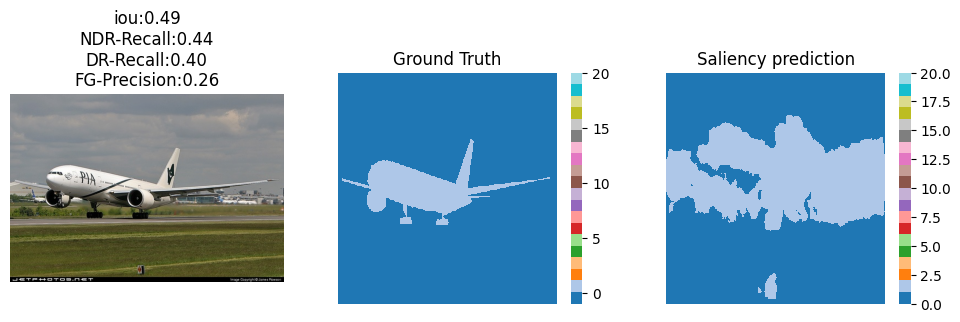

In [38]:
options = {
    'smoothing': True,
    'superpixel': False,
}

viz_first_n_saliencies(options, n=10, thres=0.15)

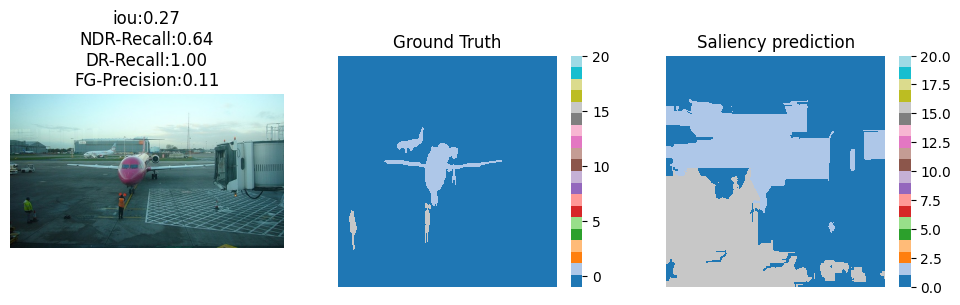

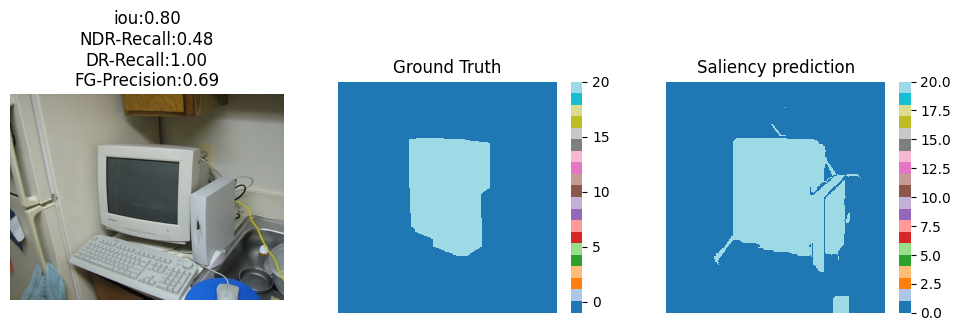

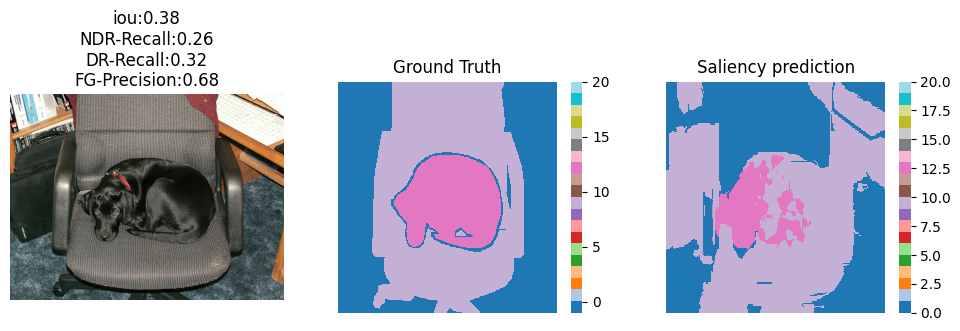

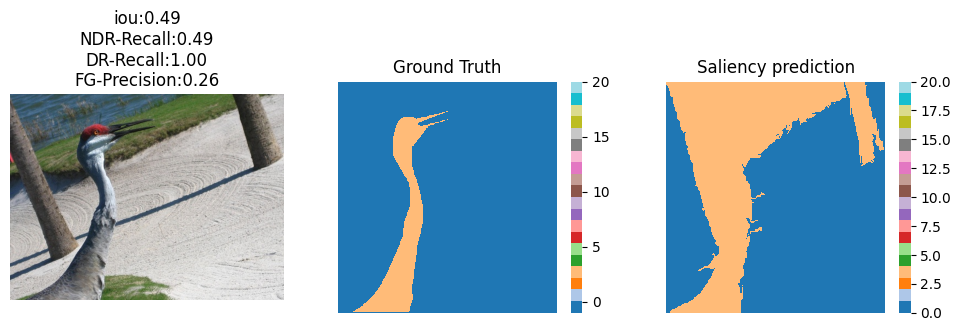

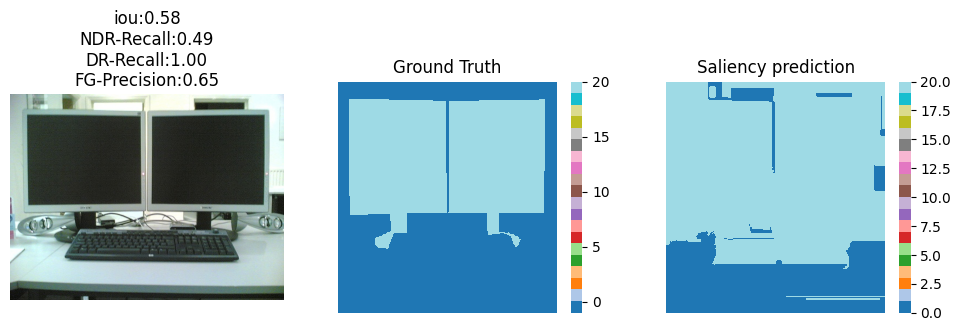

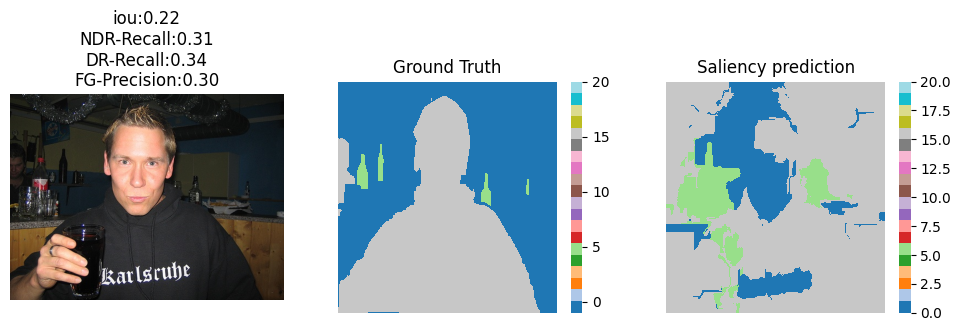

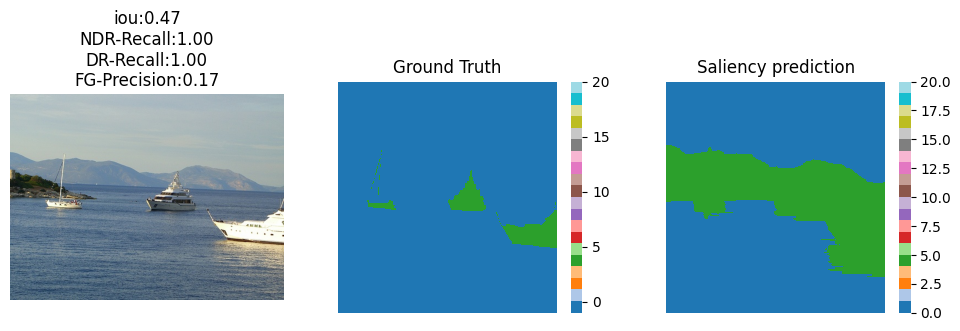

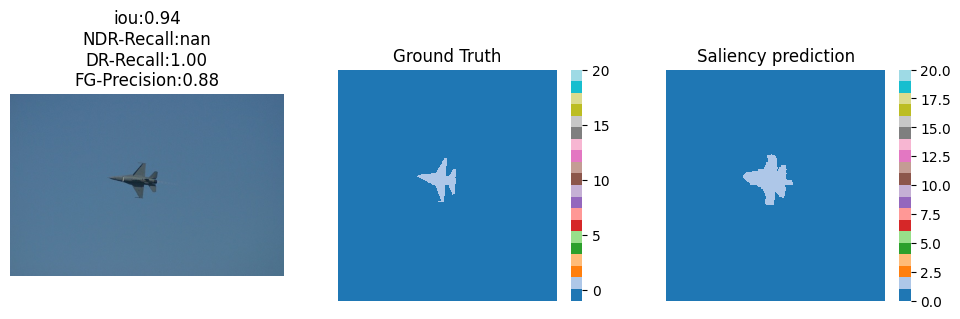

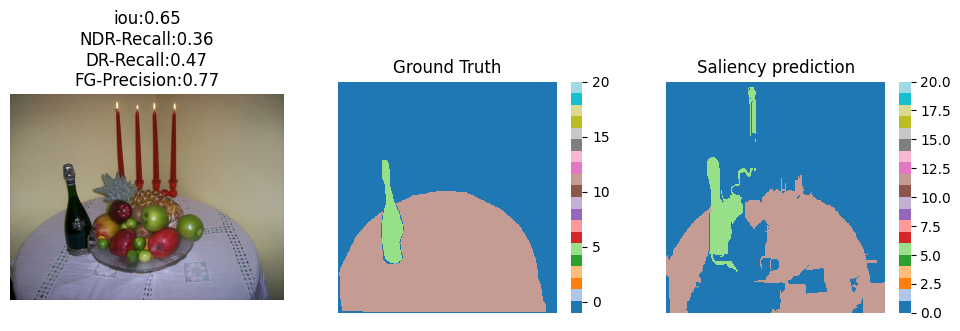

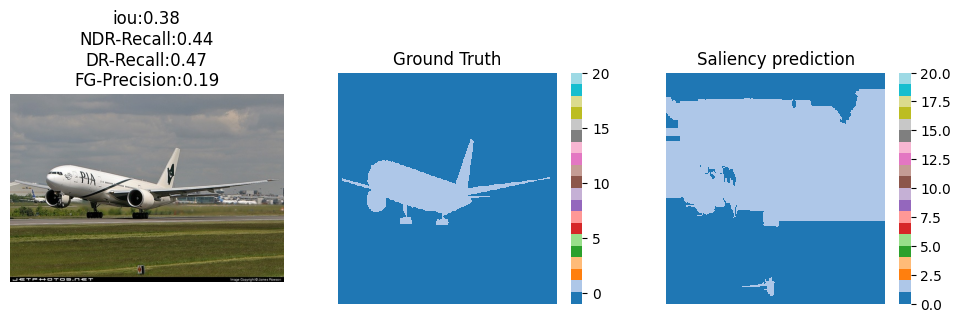

In [39]:
options = {
    'smoothing': True,
    'superpixel': True,
}

viz_first_n_saliencies(options, n=10, thres=0.15)

# mIoU for different thresholds

In [21]:
# Ground truths are in gt_labels
# NDR GTs are in ndr_gt_labels

sm_n_sp_n_thresholds = [round(i, 2) for i in np.arange(0.01, 0.15, .01)]

print(f'\n{"".join(["#" for i in range(60)])}')
print('SMOOTHING: False, SUPERPIXEL: False')
print(f'{"".join(["#" for i in range(60)])}\n')

sm_n_sp_n_miou = []
sm_n_sp_n_ndrmiou = []
sm_n_sp_n_drmiou = []
sm_n_sp_n_precision = []

for thres in sm_n_sp_n_thresholds:
    preds = get_predictions(thres=thres, smoothing=False, superpixel=False)
    
    miou = compute_miou(preds, gt_labels)
    sm_n_sp_n_miou.append(miou)
    
    ndr_miou = compute_ndr_recall(preds, ndr_gt_labels)
    sm_n_sp_n_ndrmiou.append(ndr_miou)
    
    dr_miou = compute_dr_recall(preds, dr_gt_labels)
    sm_n_sp_n_drmiou.append(dr_miou)
    
    fg_prec = compute_mPrecision(preds, gt_labels)
    sm_n_sp_n_precision.append(fg_prec)
    
    print(f'\nmIoU for {thres}: {miou}\nNDR-Recall for {thres}: {ndr_miou}\nDR-Recall for {thres}: {dr_miou}\nFG-Precision for {thres}: {fg_prec}\n\n')


############################################################
SMOOTHING: False, SUPERPIXEL: False
############################################################



100%|███████████████████████████████████████████████████████████████████████████████| 1464/1464 [00:57<00:00, 25.50it/s]



mIoU for 0.01: 0.2514674440044333
NDR-mIoU for 0.01: 0.7565316674354767
DR-mIoU for 0.01: 0.7912225763606371
FG-Precision for 0.01: 0.2666913751489717




100%|███████████████████████████████████████████████████████████████████████████████| 1464/1464 [00:58<00:00, 25.06it/s]



mIoU for 0.02: 0.2904839880655256
NDR-mIoU for 0.02: 0.7366284879750814
DR-mIoU for 0.02: 0.78760246012221
FG-Precision for 0.02: 0.30455319578295076




100%|███████████████████████████████████████████████████████████████████████████████| 1464/1464 [00:59<00:00, 24.75it/s]



mIoU for 0.03: 0.32014522982994936
NDR-mIoU for 0.03: 0.707902327823876
DR-mIoU for 0.03: 0.7801020510190756
FG-Precision for 0.03: 0.3371091512389694




100%|███████████████████████████████████████████████████████████████████████████████| 1464/1464 [00:59<00:00, 24.80it/s]



mIoU for 0.04: 0.34201555922292964
NDR-mIoU for 0.04: 0.6747093991861728
DR-mIoU for 0.04: 0.7687966019522952
FG-Precision for 0.04: 0.36499778570905955




100%|███████████████████████████████████████████████████████████████████████████████| 1464/1464 [00:59<00:00, 24.80it/s]



mIoU for 0.05: 0.357535597500336
NDR-mIoU for 0.05: 0.6395528493375043
DR-mIoU for 0.05: 0.7542906972102182
FG-Precision for 0.05: 0.38904119736240156




100%|███████████████████████████████████████████████████████████████████████████████| 1464/1464 [00:58<00:00, 24.88it/s]



mIoU for 0.06: 0.36790944831441186
NDR-mIoU for 0.06: 0.6041089349764059
DR-mIoU for 0.06: 0.7371966682680492
FG-Precision for 0.06: 0.4099445092068902




100%|███████████████████████████████████████████████████████████████████████████████| 1464/1464 [00:58<00:00, 24.86it/s]



mIoU for 0.07: 0.3741014225252813
NDR-mIoU for 0.07: 0.5692687843007113
DR-mIoU for 0.07: 0.7181909774561076
FG-Precision for 0.07: 0.4282691525916363




100%|███████████████████████████████████████████████████████████████████████████████| 1464/1464 [00:55<00:00, 26.59it/s]



mIoU for 0.08: 0.37689206954144544
NDR-mIoU for 0.08: 0.5356296292625645
DR-mIoU for 0.08: 0.6977017408024782
FG-Precision for 0.08: 0.4444421101396836




100%|███████████████████████████████████████████████████████████████████████████████| 1464/1464 [00:55<00:00, 26.59it/s]



mIoU for 0.09: 0.37692675832692357
NDR-mIoU for 0.09: 0.503479635773491
DR-mIoU for 0.09: 0.6762459941276708
FG-Precision for 0.09: 0.4588190689031329




100%|███████████████████████████████████████████████████████████████████████████████| 1464/1464 [00:55<00:00, 26.20it/s]



mIoU for 0.1: 0.37478782707019187
NDR-mIoU for 0.1: 0.4730286505289196
DR-mIoU for 0.1: 0.6542600131334639
FG-Precision for 0.1: 0.47171190797867163




100%|███████████████████████████████████████████████████████████████████████████████| 1464/1464 [00:58<00:00, 25.24it/s]



mIoU for 0.11: 0.3708560974553446
NDR-mIoU for 0.11: 0.44431504672265637
DR-mIoU for 0.11: 0.6318963875357951
FG-Precision for 0.11: 0.4832870006345525




100%|███████████████████████████████████████████████████████████████████████████████| 1464/1464 [00:57<00:00, 25.39it/s]



mIoU for 0.12: 0.3655419088004489
NDR-mIoU for 0.12: 0.4173388630701475
DR-mIoU for 0.12: 0.6094955844171542
FG-Precision for 0.12: 0.49375088546437895




100%|███████████████████████████████████████████████████████████████████████████████| 1464/1464 [00:57<00:00, 25.33it/s]



mIoU for 0.13: 0.3591427789322693
NDR-mIoU for 0.13: 0.3920741478043673
DR-mIoU for 0.13: 0.5872396066937566
FG-Precision for 0.13: 0.5032506026638064




100%|███████████████████████████████████████████████████████████████████████████████| 1464/1464 [00:57<00:00, 25.48it/s]



mIoU for 0.14: 0.35192109213218536
NDR-mIoU for 0.14: 0.3684161606013759
DR-mIoU for 0.14: 0.5653832202175201
FG-Precision for 0.14: 0.511908847637103




In [22]:
print(f'Max miou={max(sm_n_sp_n_miou)}, Max ndr-recall={max(sm_n_sp_n_ndrmiou)}, Max dr-recall={max(sm_n_sp_n_drmiou)}, Max FG-precision = {max(sm_n_sp_n_precision)}')

Max miou=0.37692675832692357, Max ndr-miou=0.7565316674354767, Max dr-miou=0.7912225763606371, Max FG-precision = 0.511908847637103


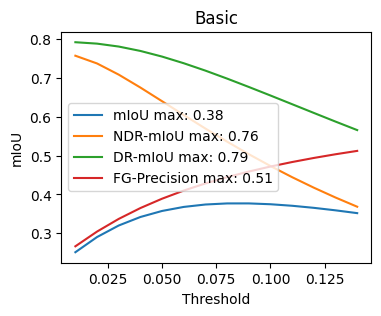

In [23]:
fig, ax = plt.subplots(figsize=(4, 3))
plt.plot(sm_n_sp_n_thresholds, sm_n_sp_n_miou, label='mIoU max: {:.2f}'.format(max(sm_n_sp_n_miou)))
plt.plot(sm_n_sp_n_thresholds, sm_n_sp_n_ndrmiou, label='NDR-Recall max: {:.2f}'.format(max(sm_n_sp_n_ndrmiou)))
plt.plot(sm_n_sp_n_thresholds, sm_n_sp_n_drmiou, label='DR-Recall max: {:.2f}'.format(max(sm_n_sp_n_drmiou)))
plt.plot(sm_n_sp_n_thresholds, sm_n_sp_n_precision, label='FG-Precision max: {:.2f}'.format(max(sm_n_sp_n_precision)))
plt.xlabel('Threshold')
plt.ylabel('mIoU')
plt.legend()
plt.title('Basic')
plt.show()

In [24]:
# Ground truths are in gt_labels
# NDR GTs are in ndr_gt_labels

sm_p_sp_n_thresholds = [round(i, 2) for i in np.arange(0.01, 0.20, .01)]

print(f'\n{"".join(["#" for i in range(60)])}')
print('SMOOTHING: True, SUPERPIXEL: False')
print(f'{"".join(["#" for i in range(60)])}\n')

sm_p_sp_n_miou = []
sm_p_sp_n_ndrmiou = []
sm_p_sp_n_drmiou = []
sm_p_sp_n_precision = []

for thres in sm_p_sp_n_thresholds:
    preds = get_predictions(thres=thres, smoothing=True, superpixel=False)
    
    miou = compute_miou(preds, gt_labels)
    sm_p_sp_n_miou.append(miou)
    
    ndr_miou = compute_ndr_recall(preds, ndr_gt_labels)
    sm_p_sp_n_ndrmiou.append(ndr_miou)
    
    dr_miou = compute_dr_recall(preds, dr_gt_labels)
    sm_p_sp_n_drmiou.append(dr_miou)
    
    fg_prec = compute_mPrecision(preds, gt_labels)
    sm_p_sp_n_precision.append(fg_prec)
    
    print(f'\nmIoU for {thres}: {miou}\nNDR-Recall for {thres}: {ndr_miou}\nDR-Recall for {thres}: {dr_miou}\nFG-Precision for {thres}: {fg_prec}\n\n')


############################################################
SMOOTHING: True, SUPERPIXEL: False
############################################################



100%|███████████████████████████████████████████████████████████████████████████████| 1464/1464 [01:40<00:00, 14.53it/s]



mIoU for 0.01: 0.2395820732221947
NDR-mIoU for 0.01: 0.8015024414544676
DR-mIoU for 0.01: 0.8208155630571115
FG-Precision for 0.01: 0.2539519468203967




100%|███████████████████████████████████████████████████████████████████████████████| 1464/1464 [01:42<00:00, 14.25it/s]



mIoU for 0.02: 0.26761577423578525
NDR-mIoU for 0.02: 0.7980863636696133
DR-mIoU for 0.02: 0.8208741299418111
FG-Precision for 0.02: 0.27896633982326813




100%|███████████████████████████████████████████████████████████████████████████████| 1464/1464 [01:41<00:00, 14.41it/s]



mIoU for 0.03: 0.29378701167512034
NDR-mIoU for 0.03: 0.7922536350199203
DR-mIoU for 0.03: 0.8208350937722815
FG-Precision for 0.03: 0.3035239636621681




100%|███████████████████████████████████████████████████████████████████████████████| 1464/1464 [01:39<00:00, 14.73it/s]



mIoU for 0.04: 0.31749040015267266
NDR-mIoU for 0.04: 0.783549400948123
DR-mIoU for 0.04: 0.8204294401375427
FG-Precision for 0.04: 0.3268542209069486




100%|███████████████████████████████████████████████████████████████████████████████| 1464/1464 [01:37<00:00, 15.05it/s]



mIoU for 0.05: 0.3386652458051267
NDR-mIoU for 0.05: 0.7725438292821023
DR-mIoU for 0.05: 0.8196885435092254
FG-Precision for 0.05: 0.3487249661992791




100%|███████████████████████████████████████████████████████████████████████████████| 1464/1464 [01:38<00:00, 14.91it/s]



mIoU for 0.06: 0.3575156855467547
NDR-mIoU for 0.06: 0.7597970770423953
DR-mIoU for 0.06: 0.8186694440686088
FG-Precision for 0.06: 0.36921331738587126




100%|███████████████████████████████████████████████████████████████████████████████| 1464/1464 [01:40<00:00, 14.57it/s]



mIoU for 0.07: 0.3742557567999036
NDR-mIoU for 0.07: 0.745363576792398
DR-mIoU for 0.07: 0.817154166760493
FG-Precision for 0.07: 0.3884791877068351




100%|███████████████████████████████████████████████████████████████████████████████| 1464/1464 [01:40<00:00, 14.59it/s]



mIoU for 0.08: 0.38879635802896656
NDR-mIoU for 0.08: 0.7290123574604037
DR-mIoU for 0.08: 0.814870549319251
FG-Precision for 0.08: 0.40642123592386836




100%|███████████████████████████████████████████████████████████████████████████████| 1464/1464 [01:39<00:00, 14.78it/s]



mIoU for 0.09: 0.40126068973831713
NDR-mIoU for 0.09: 0.711404861133766
DR-mIoU for 0.09: 0.8117536405394948
FG-Precision for 0.09: 0.42311834712821855




100%|███████████████████████████████████████████████████████████████████████████████| 1464/1464 [01:40<00:00, 14.57it/s]



mIoU for 0.1: 0.41174832614814866
NDR-mIoU for 0.1: 0.6926770270042496
DR-mIoU for 0.1: 0.8077746243149044
FG-Precision for 0.1: 0.43865963943871183




100%|███████████████████████████████████████████████████████████████████████████████| 1464/1464 [01:38<00:00, 14.81it/s]



mIoU for 0.11: 0.4203934905494014
NDR-mIoU for 0.11: 0.6730619352185542
DR-mIoU for 0.11: 0.8029634342607724
FG-Precision for 0.11: 0.4531325182085267




100%|███████████████████████████████████████████████████████████████████████████████| 1464/1464 [01:41<00:00, 14.45it/s]



mIoU for 0.12: 0.4272773298407203
NDR-mIoU for 0.12: 0.652622336245229
DR-mIoU for 0.12: 0.7973072833817182
FG-Precision for 0.12: 0.466601003918945




100%|███████████████████████████████████████████████████████████████████████████████| 1464/1464 [01:40<00:00, 14.60it/s]



mIoU for 0.13: 0.43253614668581325
NDR-mIoU for 0.13: 0.6317378774224887
DR-mIoU for 0.13: 0.7907637575071624
FG-Precision for 0.13: 0.47916492590951565




100%|███████████████████████████████████████████████████████████████████████████████| 1464/1464 [01:39<00:00, 14.71it/s]



mIoU for 0.14: 0.43629467789988285
NDR-mIoU for 0.14: 0.6106034953254168
DR-mIoU for 0.14: 0.7833052311762303
FG-Precision for 0.14: 0.49092639543234473




100%|███████████████████████████████████████████████████████████████████████████████| 1464/1464 [01:40<00:00, 14.54it/s]



mIoU for 0.15: 0.43865536505904046
NDR-mIoU for 0.15: 0.5892148819438536
DR-mIoU for 0.15: 0.7750498817850315
FG-Precision for 0.15: 0.5019558290617788




100%|███████████████████████████████████████████████████████████████████████████████| 1464/1464 [01:40<00:00, 14.58it/s]



mIoU for 0.16: 0.43979715976726913
NDR-mIoU for 0.16: 0.5678933686983753
DR-mIoU for 0.16: 0.7660317590367148
FG-Precision for 0.16: 0.5123752566502622




100%|███████████████████████████████████████████████████████████████████████████████| 1464/1464 [01:28<00:00, 16.61it/s]



mIoU for 0.17: 0.43979766635896356
NDR-mIoU for 0.17: 0.5467710152646683
DR-mIoU for 0.17: 0.7562427713179416
FG-Precision for 0.17: 0.5221679031116038




100%|███████████████████████████████████████████████████████████████████████████████| 1464/1464 [01:26<00:00, 17.00it/s]



mIoU for 0.18: 0.4387344825500021
NDR-mIoU for 0.18: 0.5258091649922698
DR-mIoU for 0.18: 0.7457213911014461
FG-Precision for 0.18: 0.531374308449896




100%|███████████████████████████████████████████████████████████████████████████████| 1464/1464 [01:26<00:00, 16.86it/s]



mIoU for 0.19: 0.4367326599773189
NDR-mIoU for 0.19: 0.505185575133434
DR-mIoU for 0.19: 0.7344963313915439
FG-Precision for 0.19: 0.5400589514303128




In [25]:
print(f'Max miou={max(sm_p_sp_n_miou)}, Max ndr-recall={max(sm_p_sp_n_ndrmiou)}, Max dr-recall={max(sm_p_sp_n_drmiou)}, Max FG-precision = {max(sm_p_sp_n_precision)}')

Max miou=0.43979766635896356, Max ndr-miou=0.8015024414544676, Max dr-miou=0.8208741299418111, Max FG-precision = 0.5400589514303128


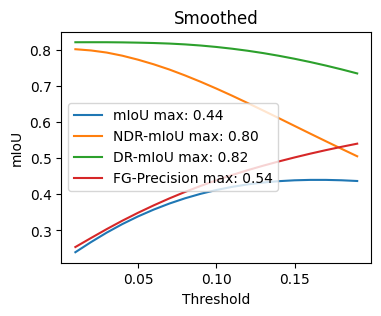

In [26]:
fig, ax = plt.subplots(figsize=(4, 3))
plt.plot(sm_p_sp_n_thresholds, sm_p_sp_n_miou, label='mIoU max: {:.2f}'.format(max(sm_p_sp_n_miou)))
plt.plot(sm_p_sp_n_thresholds, sm_p_sp_n_ndrmiou, label='NDR-Recall max: {:.2f}'.format(max(sm_p_sp_n_ndrmiou)))
plt.plot(sm_p_sp_n_thresholds, sm_p_sp_n_drmiou, label='DR-Recall max: {:.2f}'.format(max(sm_p_sp_n_drmiou)))
plt.plot(sm_p_sp_n_thresholds, sm_p_sp_n_precision, label='FG-Precision max: {:.2f}'.format(max(sm_p_sp_n_precision)))
plt.xlabel('Threshold')
plt.ylabel('mIoU')
plt.legend()
plt.title('Smoothed')
plt.show()

In [27]:
# Ground truths are in gt_labels
# NDR GTs are in ndr_gt_labels

sm_p_sp_p_thresholds = [round(i, 2) for i in np.arange(0.10, 0.30, .02)]

print(f'\n{"".join(["#" for i in range(60)])}')
print('SMOOTHING: True, SUPERPIXEL: True')
print(f'{"".join(["#" for i in range(60)])}\n')

sm_p_sp_p_miou = []
sm_p_sp_p_ndrmiou = []
sm_p_sp_p_drmiou = []
sm_p_sp_p_precision = []

for thres in sm_p_sp_p_thresholds:
    preds = get_predictions(thres=thres, smoothing=True, superpixel=True)
    miou = compute_miou(preds, gt_labels)
    sm_p_sp_p_miou.append(miou)
    
    ndr_miou = compute_ndr_recall(preds, ndr_gt_labels)
    sm_p_sp_p_ndrmiou.append(ndr_miou)
    
    dr_miou = compute_dr_recall(preds, dr_gt_labels)
    sm_p_sp_p_drmiou.append(dr_miou)
    
    fg_prec = compute_mPrecision(preds, gt_labels)
    sm_p_sp_p_precision.append(fg_prec)
    
    print(f'\nmIoU for {thres}: {miou}\nNDR-Recall for {thres}: {ndr_miou}\nDR-Recall for {thres}: {dr_miou}\nFG-Precision for {thres}: {fg_prec}\n\n')


############################################################
SMOOTHING: True, SUPERPIXEL: True
############################################################



100%|███████████████████████████████████████████████████████████████████████████████| 1464/1464 [05:05<00:00,  4.79it/s]



mIoU for 0.1: 0.4039587043163436
NDR-mIoU for 0.1: 0.7512097074034689
DR-mIoU for 0.1: 0.813790001366739
FG-Precision for 0.1: 0.42311651949405504




100%|███████████████████████████████████████████████████████████████████████████████| 1464/1464 [05:01<00:00,  4.85it/s]



mIoU for 0.12: 0.43686568194880016
NDR-mIoU for 0.12: 0.7297465178867554
DR-mIoU for 0.12: 0.8051949815023667
FG-Precision for 0.12: 0.4651387415923457




100%|███████████████████████████████████████████████████████████████████████████████| 1464/1464 [04:54<00:00,  4.98it/s]



mIoU for 0.14: 0.4615701670997521
NDR-mIoU for 0.14: 0.6913025983897497
DR-mIoU for 0.14: 0.7923198394471759
FG-Precision for 0.14: 0.5048727319671789




100%|███████████████████████████████████████████████████████████████████████████████| 1464/1464 [04:49<00:00,  5.05it/s]



mIoU for 0.16: 0.47799253536676317
NDR-mIoU for 0.16: 0.6516679547592463
DR-mIoU for 0.16: 0.7767778336642832
FG-Precision for 0.16: 0.5400476303335893




100%|███████████████████████████████████████████████████████████████████████████████| 1464/1464 [04:50<00:00,  5.04it/s]



mIoU for 0.18: 0.48748729552882475
NDR-mIoU for 0.18: 0.6123275268912627
DR-mIoU for 0.18: 0.7569133382954033
FG-Precision for 0.18: 0.5725555396340438




100%|███████████████████████████████████████████████████████████████████████████████| 1464/1464 [05:00<00:00,  4.87it/s]



mIoU for 0.2: 0.4904827308645534
NDR-mIoU for 0.2: 0.5718628460205504
DR-mIoU for 0.2: 0.7341289374182148
FG-Precision for 0.2: 0.6008980386196195




100%|███████████████████████████████████████████████████████████████████████████████| 1464/1464 [05:09<00:00,  4.73it/s]



mIoU for 0.22: 0.48647261454235474
NDR-mIoU for 0.22: 0.5313976508144397
DR-mIoU for 0.22: 0.7084742544379553
FG-Precision for 0.22: 0.6257133609235261




100%|███████████████████████████████████████████████████████████████████████████████| 1464/1464 [05:04<00:00,  4.80it/s]



mIoU for 0.24: 0.4748235669503144
NDR-mIoU for 0.24: 0.47941743340801224
DR-mIoU for 0.24: 0.6775935377489517
FG-Precision for 0.24: 0.648010648122942




100%|███████████████████████████████████████████████████████████████████████████████| 1464/1464 [05:12<00:00,  4.69it/s]



mIoU for 0.26: 0.45471265867559585
NDR-mIoU for 0.26: 0.433407547453699
DR-mIoU for 0.26: 0.6440820675694909
FG-Precision for 0.26: 0.6615680108358587




100%|███████████████████████████████████████████████████████████████████████████████| 1464/1464 [05:08<00:00,  4.75it/s]



mIoU for 0.28: 0.43543284052363745
NDR-mIoU for 0.28: 0.3922646841148711
DR-mIoU for 0.28: 0.6096033772494364
FG-Precision for 0.28: 0.6771805045579856




In [28]:
print(f'Max miou={max(sm_p_sp_p_miou)}, Max ndr-recall={max(sm_p_sp_p_ndrmiou)}, Max dr-recall={max(sm_p_sp_p_drmiou)}, Max FG-precision = {max(sm_p_sp_p_precision)}')

Max miou=0.4904827308645534, Max ndr-miou=0.7512097074034689, Max dr-miou=0.813790001366739, Max FG-precision = 0.6771805045579856


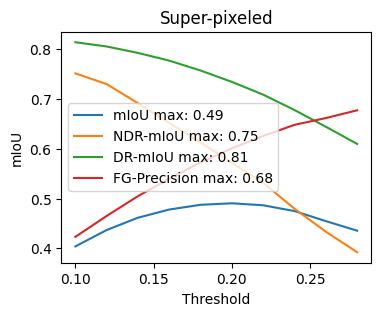

In [29]:
fig, ax = plt.subplots(figsize=(4, 3))
plt.plot(sm_p_sp_p_thresholds, sm_p_sp_p_miou, label='mIoU max: {:.2f}'.format(max(sm_p_sp_p_miou)))
plt.plot(sm_p_sp_p_thresholds, sm_p_sp_p_ndrmiou, label='NDR-Recall max: {:.2f}'.format(max(sm_p_sp_p_ndrmiou)))
plt.plot(sm_p_sp_p_thresholds, sm_p_sp_p_drmiou, label='DR-Recall max: {:.2f}'.format(max(sm_p_sp_p_drmiou)))
plt.plot(sm_p_sp_p_thresholds, sm_p_sp_p_precision, label='FG-Precision max: {:.2f}'.format(max(sm_p_sp_p_precision)))
plt.xlabel('Threshold')
plt.ylabel('mIoU')
plt.legend()
plt.title('Super-pixeled')
plt.show()

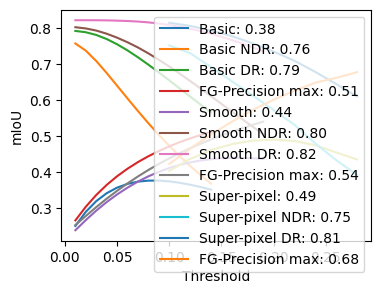

In [30]:
# all together
fig, ax = plt.subplots(figsize=(4, 3))

plt.plot(sm_n_sp_n_thresholds, sm_n_sp_n_miou, label='Basic: {:.2f}'.format(max(sm_n_sp_n_miou)))
plt.plot(sm_n_sp_n_thresholds, sm_n_sp_n_ndrmiou, label='Basic NDR: {:.2f}'.format(max(sm_n_sp_n_ndrmiou)))
plt.plot(sm_n_sp_n_thresholds, sm_n_sp_n_drmiou, label='Basic DR: {:.2f}'.format(max(sm_n_sp_n_drmiou)))
plt.plot(sm_n_sp_n_thresholds, sm_n_sp_n_precision, label='FG-Precision max: {:.2f}'.format(max(sm_n_sp_n_precision)))

plt.plot(sm_p_sp_n_thresholds, sm_p_sp_n_miou, label='Smooth: {:.2f}'.format(max(sm_p_sp_n_miou)))
plt.plot(sm_p_sp_n_thresholds, sm_p_sp_n_ndrmiou, label='Smooth NDR: {:.2f}'.format(max(sm_p_sp_n_ndrmiou)))
plt.plot(sm_p_sp_n_thresholds, sm_p_sp_n_drmiou, label='Smooth DR: {:.2f}'.format(max(sm_p_sp_n_drmiou)))
plt.plot(sm_p_sp_n_thresholds, sm_p_sp_n_precision, label='FG-Precision max: {:.2f}'.format(max(sm_p_sp_n_precision)))

plt.plot(sm_p_sp_p_thresholds, sm_p_sp_p_miou, label='Super-pixel: {:.2f}'.format(max(sm_p_sp_p_miou)))
plt.plot(sm_p_sp_p_thresholds, sm_p_sp_p_ndrmiou, label='Super-pixel NDR: {:.2f}'.format(max(sm_p_sp_p_ndrmiou)))
plt.plot(sm_p_sp_p_thresholds, sm_p_sp_p_drmiou, label='Super-pixel DR: {:.2f}'.format(max(sm_p_sp_p_drmiou)))
plt.plot(sm_p_sp_p_thresholds, sm_p_sp_p_precision, label='FG-Precision max: {:.2f}'.format(max(sm_p_sp_p_precision)))


plt.xlabel('Threshold')
plt.ylabel('mIoU')
plt.legend()

plt.show()

#### Create folders for saliencies

In [31]:
# ! mkdir -p /raid/maruf/WSS/SALIENCY/original/image/
# ! mkdir -p /raid/maruf/WSS/SALIENCY/original/image_crop/
# ! mkdir -p /raid/maruf/WSS/SALIENCY/original/image_binmask/
# ! mkdir -p /raid/maruf/WSS/SALIENCY/original/image_binmask_crop/
# ! ls /raid/maruf/WSS/SALIENCY/original/

# Report based on the best mIoU

In [32]:
# sm_n_sp_n_miou, sm_n_sp_n_ndrmiou, sm_n_sp_n_drmiou, sm_n_sp_n_precision 
idx = np.argmax(sm_n_sp_n_miou)
print('mIoU: {:.2f}, Precision: {:.2f}, DR-Recall: {:.2f}, NDR-Recall: {:.2f}'.format(sm_n_sp_n_miou[idx],
                                                                                      sm_n_sp_n_precision[idx],
                                                                                      sm_n_sp_n_drmiou[idx],
                                                                                      sm_n_sp_n_ndrmiou[idx]))


# sm_p_sp_n_miou, sm_p_sp_n_ndrmiou, sm_p_sp_n_drmiou, sm_p_sp_n_precision 
idx = np.argmax(sm_p_sp_n_miou)
print('mIoU: {:.2f}, Precision: {:.2f}, DR-Recall: {:.2f}, NDR-Recall: {:.2f}'.format(sm_p_sp_n_miou[idx],
                                                                                      sm_p_sp_n_precision[idx],
                                                                                      sm_p_sp_n_drmiou[idx],
                                                                                      sm_p_sp_n_ndrmiou[idx]))
# sm_p_sp_p_miou, sm_p_sp_p_ndrmiou, sm_p_sp_p_drmiou, sm_p_sp_p_precision
idx = np.argmax(sm_p_sp_p_miou)
print('mIoU: {:.2f}, Precision: {:.2f}, DR-Recall: {:.2f}, NDR-Recall: {:.2f}'.format(sm_p_sp_p_miou[idx],
                                                                                      sm_p_sp_p_precision[idx],
                                                                                      sm_p_sp_p_drmiou[idx],
                                                                                      sm_p_sp_p_ndrmiou[idx]))

mIoU: 0.38, Precision: 0.46, DR-Recall: 0.68, NDR-Recall: 0.50
mIoU: 0.44, Precision: 0.52, DR-Recall: 0.76, NDR-Recall: 0.55
mIoU: 0.49, Precision: 0.60, DR-Recall: 0.73, NDR-Recall: 0.57
